# STORM
### Synthesis of Topic Outlines through Retrieval and Multi-perspective question asking.

Research assistant that extends the idea of 'outline-driven RAG' for richer article generation.

It applies two main insights to produce more organized and comprehensive articles:
1. Creating an outline (planning) by querying similar topics helps improve coverage.
2. Multi-perspective, grounded (in search) conversation simulation helps increase the reference count and information density.

#### Overview
1. Generate initial outline + survey related subjects
2. Identify distiinct perspectives
3. "Interview subject matter experts" (role-playing LLMs)
4. Refine outline (using references)
5. Write sections, then write article

The expert interviews stage occurs between the role-playing article writer and a research expert. The "expert" is able to query external knowledge and respond to pointed questions, saving cited sources to a vectorstore so that the later refinement stages can synthesize the full article.

Hyperparameters to restrict the potentially infinite research breadth:
- N: number of perspectives to survey
- M: Max number of conversation turns

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### Select LLMs
We will have a faster LLM to do most of the work, but a slower, long-context model to distill the conversations and write the final report.

In [2]:
from langchain_openai import ChatOpenAI

FAST_LLM = ChatOpenAI(model='gpt-3.5-turbo')
GOOD_LLM = ChatOpenAI(model='gpt-4o')

### Generate Initial Outline
For many topics, your LLM may have an initial idea of the important and related topics. We can generate an initial outline to be referred after our research. Below, we will use our 'fast' llm to generate the outline.

In [78]:
import json
import asyncio

from langgraph.graph import END, StateGraph, START


from langchain_core.tools import tool
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_community.retrievers import WikipediaRetriever
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, ToolMessage
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.runnables import RunnableLambda, RunnableConfig, chain as as_runnable

from typing import List, Optional, Annotated, TypedDict

In [4]:
direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are a an experienced equity research analyst. Write an outline for an analysis report about a user-provided topic. Be comprehensive and specific.'
        ),
        ('user', '{topic}')
    ]
)


class Subsection(BaseModel):
    subsection_title: str = Field(..., title='Title of the subsection')
    description: str = Field(..., title='Content of the subsection')

    @property
    def as_str(self) -> str:
        return f'### {self.subsection_title}\n\n{self.description}'.strip()
    

class Section(BaseModel):
    section_title: str = Field(..., title='Title of the section')
    description: str = Field(..., title='Content of the section')
    subsections: Optional[List[Subsection]] = Field(default=None, title='Titles and descriptions for each subsection of the analysis report.')

    @property
    def as_str(self) -> str:
        subsections = '\n\n'.join(f'### {subsection.subsection_title}\n\n{subsection.description}' for subsection in self.subsections or [])
        return f'## {self.section_title}\n\n{self.description}\n\n{subsections}'.strip()
    

class Outline(BaseModel):
    page_title: str = Field(..., title='Title of the Report')
    sections: List[Section] = Field(
        default_factory=list,
        title='Titles and descriptions for each section of the Report page.'
    )

    @property
    def as_str(self) -> str:
        sections = '\n\n'.join(section.as_str for section in self.sections)
        return f'# {self.page_title}\n\n{sections}'.strip()
    
generate_outline_direct = direct_gen_outline_prompt | FAST_LLM.with_structured_output(Outline)

In [5]:
example_topic = 'Impact on silicon industry due to the China Taiwan war'

In [6]:
initial_outline = generate_outline_direct.invoke({'topic': example_topic})

In [7]:
print(initial_outline.as_str)

# Analysis Report: Impact of China-Taiwan Conflict on Silicon Industry

## Introduction

Provide an overview of the China-Taiwan conflict and its potential implications on the silicon industry.

## Current State of the Silicon Industry

Discuss the current trends, key players, market size, and growth drivers in the global silicon industry.

## Dependency on Taiwan in the Silicon Industry

Examine the extent to which the silicon industry is dependent on Taiwan for raw materials, manufacturing, and technology.

## Potential Disruptions in the Supply Chain

Assess the potential disruptions in the silicon industry's supply chain due to the China-Taiwan conflict, including implications for production, pricing, and availability.

## Impact on Key Players and Market Dynamics

Analyze how major players in the silicon industry, such as TSMC, Intel, and Samsung, may be affected by the conflict, and how market dynamics could shift.

## Mitigation Strategies and Contingency Plans

Explore potentia

### Expand topics
While language models do store some Wikipedia-like knowledge in their parameters, you will get better results by incorporating relevant and recent information using a search engine.

We will start our search by generating a list of related topics, sourced from Wikipedia.

In [8]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    '''I'm writing a financial report for a topic mentioned below. Please identify and recommend some Wikipedia pages on closely related subjects.
    I'm looking for examples that provide insights into interesting aspects commonly associated with this topic, or examples that help me understand the typical content and structure included in Wikipedia pages for similar topics.
    Please list as many subjects and urls as you can.

    Topic of interest: {topic}''')

class RelatedSubjects(BaseModel):
    topics: List[str] = Field(description='Comprehensive list of related subjects as background research')

expand_chain = gen_related_topics_prompt | FAST_LLM.with_structured_output(RelatedSubjects)

In [9]:
related_subjects = await expand_chain.ainvoke({'topic': example_topic})
related_subjects

RelatedSubjects(topics=['Silicon Industry', 'China-Taiwan Conflict', 'Technology Impact', 'Economic Impact'])

### Generate Perspectives

From these related subjects, we can select representative Wikipedia editors as 'subject matter experts' with distinct backgrounds and affiliations. These will help distribute the research process to encourage a more well-rounded final report.

In [10]:
class Editor(BaseModel):
    affiliation: str = Field(description='Primary affiliation of the editor.')
    name: str = Field(description='Name of the editor', pattern=r'^[a-zA-Z0-9_-]{1,64}$')
    role: str = Field(description='Role of the editor in the context of the topic.')
    description: str = Field(description='Description of the editor\'s focus, concerns and motives')

    @property
    def persona(self) -> str:
        return f'Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n'
    

class Perspectives(BaseModel):
    editors: List[Editor] = Field(description='Comprehensive list of editors with their roles and affiliations.')


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You need to select a diverse (and distinct) group of equity research analysts, equity researchers and editors who will work together to create a comprehensive article on the topic. Each of them represents a different perspective, role, or affiliation related to this topic. 
            You can use other Wikipedia pages of related topics for inspiration. For each editor, add a description of what they will focus on. 
            
            Wiki pages outlines of related topics for inspiration: 
            {examples}''',
        ),
        (
            'user'
            'Topic of interest: {topic}'
        )
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | FAST_LLM.with_structured_output(Perspectives)

In [11]:
wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)

def format_doc(doc, max_length=1000):
    related = '- '.join(doc.metadata['categories'])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[:max_length]

def format_docs(docs):
    return '\n\n'.join(format_doc(doc) for doc in docs)

@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({'topic': topic})
    retrieved_docs = await wikipedia_retriever.abatch(related_subjects.topics, return_exceptions=True)
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({'examples': formatted, 'topic': topic})

In [12]:
perspectives = await survey_subjects.ainvoke(example_topic)

In [13]:
perspectives.dict()

{'editors': [{'affiliation': 'Equity Research Analyst',
   'name': 'AliceSmith',
   'role': 'Equity Research Analyst',
   'description': 'Alice will focus on analyzing the impact of the China-Taiwan conflict on the silicon industry, including supply chain disruptions, market trends, and potential investment opportunities.'},
  {'affiliation': 'Equity Researcher',
   'name': 'JohnDoe',
   'role': 'Equity Researcher',
   'description': 'John will provide insights on the technological advancements in the silicon industry, the role of Taiwan and China in semiconductor production, and the implications of the conflict on global tech markets.'},
  {'affiliation': 'Editor',
   'name': 'EmilyJones',
   'role': 'Editor',
   'description': "Emily will oversee the article's structure, ensuring a balanced representation of viewpoints, accuracy in information, and coherence in discussing the impact of the China-Taiwan conflict on the silicon industry."}]}

### Expert Dialog
Each wikipedia writer is primed to role-play using the perspectives presented above. It will ask a series of questions of a second "domain expert" with access to a search engine. This generates content to generate a refined outline as well as an updated index of reference documents.

### Interview State
The conversation is cyclic, so we will construct it within its own graph. The State will contain messages, the reference docs, and the editor (with its own "persona") to make it easy to parallelize these conversations.

In [14]:
def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right

def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references

def update_editor(editor, new_editor):
    # can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

### Dialog roles
The graph will have two participants: the wikipedia editor (`generate_question`), who asks questions based on its assigned role, and a domain expert (`gen_answer_chain`), who uses a search engine to answer the questions as accurately as possible.

In [15]:
gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are an experienced equity research analyst with great critical thinking skills. 
            You want to edit a specific report. 
            Besides your exceptional writing skills, you have a specific focus when researching the topic. 
            Now you are chatting with an expert to get information. Ask good questions to get more useful information. 
            Make sure to get answers for specific industries, specific companies or ticker symbols and verticals within companies, as and when relevant. 
            
            When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation. 
            Please only ask one question at a time and don't ask what you have asked before. 
            Be comprehensive and curious, gaining as much unique insight from the expert as possible.
            
            Stay true to your specific perspective: 
            
            {persona}''',
        ),
        MessagesPlaceholder(variable_name='messages', optional=True)
    ]
)

def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message

def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state['messages']:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={'type'}))
        converted.append(message)
    return {'messages': converted}

@as_runnable
async def generate_question(state: InterviewState):
    editor = state['editor']
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | FAST_LLM
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {'messages': [result]}

In [16]:
messages = [
    HumanMessage(f'So you said you were writing an article on {example_topic}?')
]

question = await generate_question.ainvoke(
    {
        'editor': perspectives.editors[0],
        'messages': messages
    }
)

question['messages'][0].content

"Yes, that's correct. I am focusing on analyzing the impact of the China-Taiwan conflict on the silicon industry, including supply chain disruptions, market trends, and potential investment opportunities. Do you have any insights or information regarding how this conflict could specifically affect the silicon industry?"

### Answer Questions
The `gen_answer_chain` first generates queries (query expansion) to answer the editor's question, then responds with citations.

In [17]:
class Queries(BaseModel):
    queries: List[str] = Field(description='Comprehensive list of search engine queries to answer the user\'s question')

gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are a helpful equity research assistant. Query the search engine to answer the user\'s questions.'
        ),
        MessagesPlaceholder(variable_name='messages', optional=True)
    ]
)
gen_queries_chain = gen_queries_prompt | GOOD_LLM.with_structured_output(Queries, include_raw=True)

In [18]:
queries = await gen_queries_chain.ainvoke({'messages': [HumanMessage(content=question['messages'][0].content)]})
queries['parsed'].queries

['China-Taiwan conflict impact on silicon industry',
 'China-Taiwan tensions silicon supply chain',
 'China-Taiwan conflict semiconductor market trends',
 'China-Taiwan conflict investment opportunities silicon industry',
 'China-Taiwan impact on silicon production',
 'China-Taiwan conflict technology industry effects',
 'China-Taiwan tensions and global semiconductor market']

In [19]:
class AnswersWithCitations(BaseModel):
    answer: str = Field(description='Comprehensive answer to the user\'s question with citations.')
    cited_urls: List[str] = Field(
        description='List of urls cited in the answer.',
    )

    @property
    def as_str(self) -> str:
        return f'{self.answer}\n\nCitations:\n\n' + '\n'.join(
            f'[{i+1}: {url}]' for i, url in enumerate(self.cited_urls)
        )
    
gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are an expert equity research analyst who can use information effectively. 
            You are chatting with an equity research report writer who wants to write an analysis report on the topic you know. 
            You have gathered the related information and will now use the information to form a response. 
            
            Make your response as informative as possible and make sure every sentence is supported by the gathered information. 
            Be sure to mention specific industries, companies and verticals within companies as required. 
            Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLs after your response.'''
        ),
        MessagesPlaceholder(variable_name='messages', optional=True)
    ]
)

gen_answer_chain = gen_answer_prompt | GOOD_LLM.with_structured_output(AnswersWithCitations, include_raw=True).with_config(run_name='GenerateAnswer')

In [20]:
# Tavily is typically a better search engine but free queries are limited.
# search_engine = TavilySearchResults(max_results=4)

# @tool
# async def search_engine(query: str):
#     '''Search engine to the internet'''
#     results = tavily_search.invoke(query)
#     return [{'content': r['content'], 'url': r['url']} for r in results]

# DDG
search_engine = DuckDuckGoSearchAPIWrapper()

@tool
async def search_engine(query: str):
    '''Search engine to the internet'''
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{'content': r['body'], 'url': r['href']} for r in results]

In [21]:
async def gen_answer(state: InterviewState, config: Optional[RunnableConfig]=None, name: str='subject_matter_expert', max_str_len: int=15000):
    swapped_state = swap_roles(state, name) # convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(queries['parsed'].queries, config, return_exceptions=True)
    successful_results = [res for res in query_results if not isinstance(res, Exception)]
    all_query_results = {res['url']: res['content'] for results in successful_results for res in results}

    # we could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries['raw']
    tool_call = queries['raw'].additional_kwargs['tool_calls'][0]
    tool_id = tool_call['id']
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state['messages'].extend([ai_message, tool_message])

    # only update the shared state with the final answer to avoid polluting the dialog history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated['parsed'].cited_urls)

    # save the retrieved information to the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated['parsed'].as_str)
    return {'messages': [formatted_message], 'references': cited_references}

In [22]:
example_answer = await gen_answer(
    {'messages': [HumanMessage(content=question['messages'][0].content)]}
)

In [23]:
print(example_answer['messages'][-1].content)

The China-Taiwan conflict has significant implications for the silicon industry, particularly in terms of supply chain disruptions, market trends, and investment opportunities. Taiwan is a critical player in the global semiconductor market, producing 65% of the world's semiconductors and around 90% of the most advanced chips[^1^]. The looming threat of an invasion by China places this supply chain in jeopardy, potentially causing severe disruptions globally[^2^]. Such disruptions can lead to shortages of critical components, affecting industries that rely heavily on these semiconductors, such as consumer electronics, automotive, and telecommunications[^3^].

The tension has already led companies to reassess their supply chain dependencies. For instance, the Taiwan Semiconductor Manufacturing Company (TSMC) has been exploring the possibility of moving some of its fabrication plants out of Taiwan, although such a move would be highly complex and costly[^4^]. Additionally, geopolitical fa

### Construct the Interview Graph

In [24]:
max_num_turns = 5

def route_messages(state: InterviewState, name: str='subject_matter_expert'):
    messages = state['messages']
    num_responses = len([m for m in messages if isinstance(m, AIMessage) and m.name == name])
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]

    if last_question.content.endswith('Thank you so much for your help!'):
        return END
    
    return 'ask_question'

builder = StateGraph(InterviewState)

builder.add_node('ask_question', generate_question)
builder.add_node('answer_question', gen_answer)
builder.add_conditional_edges('answer_question', route_messages)
builder.add_edge('ask_question', 'answer_question')
builder.add_edge(START, 'ask_question')
interview_graph = builder.compile().with_config(run_name='Conduct Interviews')

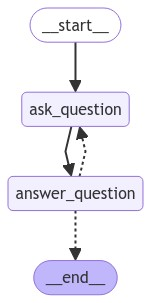

In [25]:
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(Image(interview_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [27]:
final_step = None

initial_state = {
    'editor': perspectives.editors[0],
    'messages': [
        AIMessage(
            content=f'So you said you were writing an article on {example_topic}?',
            name='subject_matter_expert'
        )
    ]
}

all_steps = []
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print(step)
    print('--', str(step[name]['messages'])[:300])
    all_steps.append(step)
    if END in step:
        final_step = step

ask_question
{'ask_question': {'messages': [AIMessage(content="Yes, that's correct. I am focusing on analyzing the impact of the China-Taiwan conflict on the silicon industry, including supply chain disruptions, market trends, and potential investment opportunities. Do you have insights into how this conflict is affecting specific companies within the silicon industry?", response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 254, 'total_tokens': 309}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, name='AliceSmith', id='run-8013add3-3d8c-424d-931e-b6da330ede31-0')]}}
-- [AIMessage(content="Yes, that's correct. I am focusing on analyzing the impact of the China-Taiwan conflict on the silicon industry, including supply chain disruptions, market trends, and potential investment opportunities. Do you have insights into how this conflict is affecting specific companies 
answer_question
{'answer_question': {'messag

In [55]:
all_references = dict()
for step in all_steps:
    if 'answer_question' in step:
        for k, v in step['answer_question']['references'].items():
            all_references[k] = v

all_references

{'https://www.theatlantic.com/international/archive/2024/06/china-microchip-technology-competition/678612/': "Xi not only has hampered Beijing's attainment of great-power status, but has actually achieved the reverse: By choosing a China hostile to the U.S., he now leads a weaker China. Michael Schuman ...",
 'https://www.bakerinstitute.org/research/silicon-hegemon-could-china-take-over-taiwans-semiconductor-industry-without-invading': 'In October 2022, the United States imposed restrictions on the sale of high-performance semiconductors to China in defense of American strategic technology and national security interests. The export controls cover advanced chips as well as machinery and human assistance for manufacturing them. Semiconductor chips are perhaps the most strategic resource of the present era, offering power ...',
 'https://www.vox.com/technology/2024/4/4/24120498/taiwan-hualien-earthquake-magnitude-tsmc-semiconductor-china-natural-disaster-global-economy': 'by Bryan Walsh.

In [56]:
final_state = next(iter(step.values()))

In [57]:
final_state['messages'][0].content

'Smaller semiconductor companies are navigating the challenges posed by the China-Taiwan conflict through a variety of strategies aimed at ensuring supply chain resilience and continuity. One of the primary approaches is diversifying their supply chains to reduce reliance on any single geographical area. Companies are increasingly sourcing components from multiple regions to mitigate the risk of disruptions. For instance, they are exploring partnerships with manufacturers in countries like South Korea, Japan, and the United States, which are ramping up their semiconductor production capabilities to create more balanced and resilient supply chains.[1] Additionally, smaller companies are investing in supply chain visibility and transparency technologies. These technologies enable them to better monitor and manage their supply chains, identify potential bottlenecks or disruptions early on, and take proactive measures to address them. Enhanced supply chain visibility can also help companie

## Refine Outline
At this point in STORM, we've conducted a large amount of research from different perspectives. 
It's time to refine the original outline based on these investigations. Below, create a chain using the LLM with a long context window to update the original outline.

In [58]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are a critical equity research analyst. You have gathered information from experts and search engines. Now, you are refining the outline of the financial report you were writing. 
            You need to make sure that the outline is comprehensive and specific. 
            This is the topic you are writing about: {topic}

            Old outline:
            {old_outline}
            '''
        ),
        (
            'user',
            'Refine the outline based on your conversations with subject-matter experts:\n\nConversations:\n\n{conversations}\n\nWrite the refined financial report outline.'
        )
    ]
)

refine_outline_chain = refine_outline_prompt | GOOD_LLM.with_structured_output(Outline)

In [59]:
refined_outline = refine_outline_chain.invoke(
    {
        'topic': example_topic,
        'old_outline': initial_outline.as_str,
        'conversations': '\n\n'.join(
            f'## {m.name}\n\n{m.content}' for m in final_state['messages']
        )
    }
)

In [60]:
print(refined_outline.as_str)

# Impact of China-Taiwan Conflict on Silicon Industry

## Introduction

Provide an overview of the China-Taiwan conflict and its potential implications on the silicon industry.

## Current State of the Silicon Industry

Discuss the current trends, key players, market size, and growth drivers in the global silicon industry.

## Dependency on Taiwan in the Silicon Industry

Examine the extent to which the silicon industry is dependent on Taiwan for raw materials, manufacturing, and technology.

## Potential Disruptions in the Supply Chain

Assess the potential disruptions in the silicon industry's supply chain due to the China-Taiwan conflict, including implications for production, pricing, and availability.

## Impact on Key Players and Market Dynamics

Analyze how major players in the silicon industry, such as TSMC, Intel, and Samsung, may be affected by the conflict, and how market dynamics could shift.

### Major Players Analysis

Detailed analysis of how major companies like TSMC, I

### Create Retriever
The research process uncovers a large number of reference documents that we may want to query during the final article-writing process.

In [61]:
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
reference_docs = [
    Document(page_content=v, metadata={'source': 'k'})
    for k, v in all_references.items()
]

# doesn't need a vectorstore for this size of data but this is just a POC
vectorstore = SKLearnVectorStore.from_documents(
    reference_docs,
    embedding=embeddings,
    n_neighbors=4
)
retriever = vectorstore.as_retriever(k=10)

In [62]:
reference_docs

[Document(metadata={'source': 'k'}, page_content="Xi not only has hampered Beijing's attainment of great-power status, but has actually achieved the reverse: By choosing a China hostile to the U.S., he now leads a weaker China. Michael Schuman ..."),
 Document(metadata={'source': 'k'}, page_content='In October 2022, the United States imposed restrictions on the sale of high-performance semiconductors to China in defense of American strategic technology and national security interests. The export controls cover advanced chips as well as machinery and human assistance for manufacturing them. Semiconductor chips are perhaps the most strategic resource of the present era, offering power ...'),
 Document(metadata={'source': 'k'}, page_content='by Bryan Walsh. Apr 4, 2024, 6:00 AM PDT. Rescue teams demolish a building which collapsed following an earthquake on April 3, 2024 in Hualien, Taiwan. Annabelle Chih/Getty Images. Bryan Walsh is ...'),
 Document(metadata={'source': 'k'}, page_content

In [63]:
retriever.invoke(example_topic)

[Document(metadata={'id': 'd16c47ab-6095-4ee6-a7a1-67a5e6e7e8b9', 'source': 'k'}, page_content='Despite the China tensions, the topic of a possible war and its impact on chip supply chains has barely featured at the annual Computex technology trade show this week in Taipei, unless brought up ...'),
 Document(metadata={'id': '1d15cd7e-934a-4275-8a23-f8ed2ce1ce2b', 'source': 'k'}, page_content='The U.S.-China chip war centers on Taiwan, where most advanced chips for the likes of Nvidia and Apple are made. The upcoming Taiwan presidential election may be a turning point.'),
 Document(metadata={'id': '407b1ff5-5a5c-4f0f-a796-290451cc6819', 'source': 'k'}, page_content="TAIPEI -- At least five suppliers to Taiwan Semiconductor Manufacturing Co. and Intel have delayed construction of facilities in Arizona, a sign that rebuilding America's chip supply chain is a ..."),
 Document(metadata={'id': 'b0e8aa2e-44ea-4545-b741-1a5c6842dc6a', 'source': 'k'}, page_content='In October 2022, the United S

### Generate Sections

In [66]:
class Subsection(BaseModel):
    subsection_title: str = Field(..., title='Title of the subsection')
    content: str = Field(..., title='Full content of the subsection. Include [#] citations to the cited sources where relevant')

    @property
    def as_str(self) -> str:
        return f'### {self.subsection_title}\n\n{self.content}'.strip()
    

class ContentsSection(BaseModel):
    section_title: str = Field(..., title='Title of the section')
    content: str = Field(..., title='Full content of the section')
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title='Titles and descriptions of each subsection of the financial report'
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = '\n\n'.join(subsection.as_str for subsection in self.subsections or [])
        citations = '\n'.join([f' [{i}] {cit}' for i, cit in enumerate(self.citations)])
        return (
            f'## {self.section_title}\n\n{self.content}\n\n{subsections}'.strip() +
            f'\n\n{citations}'.strip()
        )
    
section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are an expert equity research analyst. Complete your assigned section from the following outline: \n\n'
            '{outline}\n\nCite your sources, using the following references:\n\n<Documents>\n{docs}\n</Documents>'
        ),
        (
            'user',
            'Write the full report section for the {section} section.'
        )
    ]
)

async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs['topic'] + ': ' + inputs['section'])
    formatted = '\n'.join([f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>' for doc in docs])
    return {'docs': formatted, **inputs}

section_writer = (
    retrieve
    | section_writer_prompt
    | GOOD_LLM.with_structured_output(ContentsSection)
)

In [67]:
section = await section_writer.ainvoke(
    {
        'outline': refined_outline.as_str,
        'section': refined_outline.sections[1].section_title,
        'topic': example_topic
    }
)

print(section.as_str)

## Current State of the Silicon Industry

The global silicon industry is a fundamental component of modern technology, underpinning a broad range of electronic devices and systems. Silicon is a critical material used in the production of semiconductors, which are essential for a wide array of applications including computing, telecommunications, automotive, and consumer electronics. As the backbone of the semiconductor industry, silicon's role cannot be overstated.

### Current Trends
The silicon industry is currently experiencing several significant trends. Firstly, there is a growing demand for semiconductors driven by the proliferation of consumer electronics, the expansion of the Internet of Things (IoT), advancements in artificial intelligence (AI), and the rollout of 5G technology. These applications require increasingly sophisticated and powerful chips, which in turn drives demand for high-purity silicon.

Secondly, there is a notable shift towards more advanced semiconductor ma

In [69]:
from IPython.display import Markdown

In [70]:
Markdown(section.as_str)

## Current State of the Silicon Industry

The global silicon industry is a fundamental component of modern technology, underpinning a broad range of electronic devices and systems. Silicon is a critical material used in the production of semiconductors, which are essential for a wide array of applications including computing, telecommunications, automotive, and consumer electronics. As the backbone of the semiconductor industry, silicon's role cannot be overstated.

### Current Trends
The silicon industry is currently experiencing several significant trends. Firstly, there is a growing demand for semiconductors driven by the proliferation of consumer electronics, the expansion of the Internet of Things (IoT), advancements in artificial intelligence (AI), and the rollout of 5G technology. These applications require increasingly sophisticated and powerful chips, which in turn drives demand for high-purity silicon.

Secondly, there is a notable shift towards more advanced semiconductor manufacturing processes. Leading-edge technologies such as 7nm, 5nm, and even 3nm process nodes are becoming more prevalent as companies strive to pack more transistors onto silicon wafers, thereby enhancing performance and energy efficiency.

### Key Players
The silicon industry is dominated by a few key players who control significant market share and influence technological advancements. Taiwan Semiconductor Manufacturing Company (TSMC) is the largest and most advanced semiconductor foundry in the world, providing cutting-edge manufacturing capabilities to a variety of clients. Intel Corporation, a leading player in the semiconductor industry, is known for its innovation in processor technology and significant investments in manufacturing infrastructure. Samsung Electronics also plays a major role, particularly in memory chips and increasingly in logic chips.

### Market Size and Growth Drivers
The market size of the global silicon industry is substantial and continues to grow. According to recent estimates, the semiconductor market was valued at approximately $440 billion in 2020 and is projected to reach over $600 billion by 2026, driven by robust demand across various sectors. Key growth drivers include the increasing adoption of smart devices, the expansion of cloud computing, the rise of electric vehicles (EVs), and technological advancements in AI and machine learning.

### Conclusion
In summary, the silicon industry is at the heart of the technological revolution, with strong demand and continuous innovation driving its growth. The dominance of key players like TSMC, Intel, and Samsung, coupled with rapid advancements in semiconductor manufacturing processes, ensures that this industry will remain a critical component of the global economy for the foreseeable future.[0] k

### Generate final article

In [74]:
writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are an expert equity research analyst. Write the complete financial report on {topic} using the following section drafts: \n\n'
            '{draft}\n\nStrictly follow wikipedia format guidelines.'
        ),
        (
            'user',
            'Write the complete financial report using markdown format. Organize citations using footnotes like "[1]", '
            'avoiding duplicates in the footer. Include URLs in the footer.'
        )
    ]
)

writer = writer_prompt | GOOD_LLM | StrOutputParser()

In [76]:
# for tok in writer.stream({'topic': example_topic, 'draft': section.as_str}):
#     print(tok, end='')
example_response = writer.invoke({'topic': example_topic, 'draft': section.as_str})
Markdown(example_response)

# Financial Report: Impact on the Silicon Industry Due to the China-Taiwan War

## Current State of the Silicon Industry

The global silicon industry is a fundamental component of modern technology, underpinning a broad range of electronic devices and systems. Silicon is a critical material used in the production of semiconductors, which are essential for a wide array of applications including computing, telecommunications, automotive, and consumer electronics. As the backbone of the semiconductor industry, silicon's role cannot be overstated.

### Current Trends

The silicon industry is currently experiencing several significant trends. Firstly, there is a growing demand for semiconductors driven by the proliferation of consumer electronics, the expansion of the Internet of Things (IoT), advancements in artificial intelligence (AI), and the rollout of 5G technology. These applications require increasingly sophisticated and powerful chips, which in turn drives demand for high-purity silicon.

Secondly, there is a notable shift towards more advanced semiconductor manufacturing processes. Leading-edge technologies such as 7nm, 5nm, and even 3nm process nodes are becoming more prevalent as companies strive to pack more transistors onto silicon wafers, thereby enhancing performance and energy efficiency.

### Key Players

The silicon industry is dominated by a few key players who control significant market share and influence technological advancements. Taiwan Semiconductor Manufacturing Company (TSMC) is the largest and most advanced semiconductor foundry in the world, providing cutting-edge manufacturing capabilities to a variety of clients[1]. Intel Corporation, a leading player in the semiconductor industry, is known for its innovation in processor technology and significant investments in manufacturing infrastructure[2]. Samsung Electronics also plays a major role, particularly in memory chips and increasingly in logic chips[3].

### Market Size and Growth Drivers

The market size of the global silicon industry is substantial and continues to grow. According to recent estimates, the semiconductor market was valued at approximately $440 billion in 2020 and is projected to reach over $600 billion by 2026, driven by robust demand across various sectors[4]. Key growth drivers include the increasing adoption of smart devices, the expansion of cloud computing, the rise of electric vehicles (EVs), and technological advancements in AI and machine learning.

### Conclusion

In summary, the silicon industry is at the heart of the technological revolution, with strong demand and continuous innovation driving its growth. The dominance of key players like TSMC, Intel, and Samsung, coupled with rapid advancements in semiconductor manufacturing processes, ensures that this industry will remain a critical component of the global economy for the foreseeable future.

---

[1]: https://www.tsmc.com/english
[2]: https://www.intel.com
[3]: https://www.samsung.com
[4]: https://www.statista.com/statistics/266973/global-semiconductor-sales-since-1988/

## Final Flow
6 main stages in sequence:
1. Generate the initial outline + perspectives
2. Batch converse with each perspective to expand the content for the article
3. Refine the outline based on the conversations
4. Index the reference docs from the conversations
5. Write the individual sections of the article
6. Write the final financial report

In [77]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]

    # the final sections output
    sections: List[ContentsSection]
    article: str

In [80]:
import asyncio

async def initialize_research(state: ResearchState):
    topic = state['topic']
    coros = (
        generate_outline_direct.ainvoke({'topic': topic}), 
        survey_subjects.ainvoke(topic)
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        'outline': results[0],
        'editors': results[1].editors
    }

async def conduct_interviews(state: ResearchState):
    topic = state['topic']
    initial_states = [
        {
            'editor': editor,
            'messages': [
                AIMessage(
                    content=f'So you said you were writing an article on {topic}?',
                    name='subject_matter_expert'
                )
            ]
        }
        for editor in state['editors']
    ]

    # we call into the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        'interview_results': interview_results
    }

def format_conversation(interview_state):
    messages = interview_state['messages']
    convo = '\n'.join(f'{m.name}: {m.content}' for m in messages)
    return f'Conversation with {interview_state["editor"].name}\n\n' + convo

async def refine_outline(state: ResearchState):
    convos = '\n\n'.join([format_conversation(interview_state) for interview_state in state['interview_results']])
    updated_outline = await refine_outline_chain.ainvoke({
        'topic': state['topic'],
        'old_outline': state['outline'].as_str,
        'conversations': convos
    })
    return {**state, 'outline': updated_outline}

async def index_references(state: ResearchState):
    all_docs = []
    for interview_state in state['interview_results']:
        reference_docs = [Document(page_content=v, metadata={'source': k}) for k, v in interview_state['references'].items()]
        all_docs.extend(reference_docs)
    await vectorstore.aadd_documents(all_docs)
    return state

async def write_sections(state: ResearchState):
    outline = state['outline']
    sections = await section_writer.abatch(
        [
            {
                'outline': refine_outline.as_str,
                'section': section.section_title,
                'topic': state['topic']
            }
            for section in outline.sections
        ]
    )

    return {
        **state,
        'sections': sections
    }

async def write_article(state: ResearchState):
    topic = state['topic']
    sections = state['sections']
    draft = '\n\n'.join([section.as_str for section in sections])
    article = await writer.ainvoke({'topic': topic, 'draft': draft})
    return {**state, 'article': article}